In [2]:
from genealogy_aligner import *
import matplotlib.pyplot as plt
import msprime as msp
import tskit
from IPython.display import SVG
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [3]:
# Map tskit ids to the individuals from the pedigree
def map_ind_ids(ts):
    mapping = {}
    for n in ts.nodes():
        if n.individual != -1:
            ind_info = ts.individual(n.individual)
            mapping[n.id] = (int(ind_info.metadata.decode()), n.id)
        else:
            mapping[n.id] = (-1, n.id)
    return mapping

In [4]:
ped_file = '../data/test/loop_4.tsv'
probands = [20, 21]

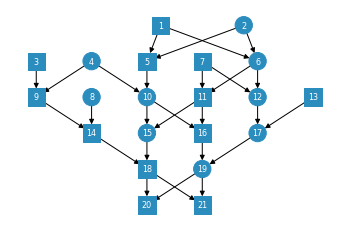

In [5]:
Q = Pedigree.from_balsac_table(ped_file)
fig, ax = plt.subplots()
Q.draw(ax=ax)
fig.savefig('../fig/loop_4.svg')

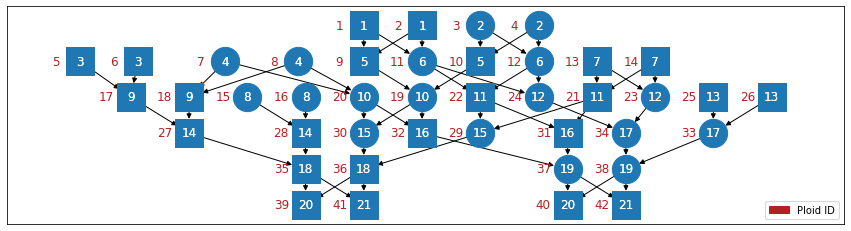

In [6]:
D = DiploidGraph(Q)
D.draw(figsize=(15,4))

In [7]:
P = msp.Pedigree.read_txt(ped_file)
P.set_samples(sample_IDs=probands, probands_only=True)
end_time = max(P.time)
des = [msp.SimulationModelChange(end_time, 'hudson')]

In [8]:
seed = 241

In [9]:
ts = msp.simulate(
            len(probands), Ne=1000, pedigree=P,
            model='wf_ped', demographic_events=des, random_seed=seed,
            recombination_rate=5e-3)

labels = map_ind_ids(ts)
ts.num_trees

6

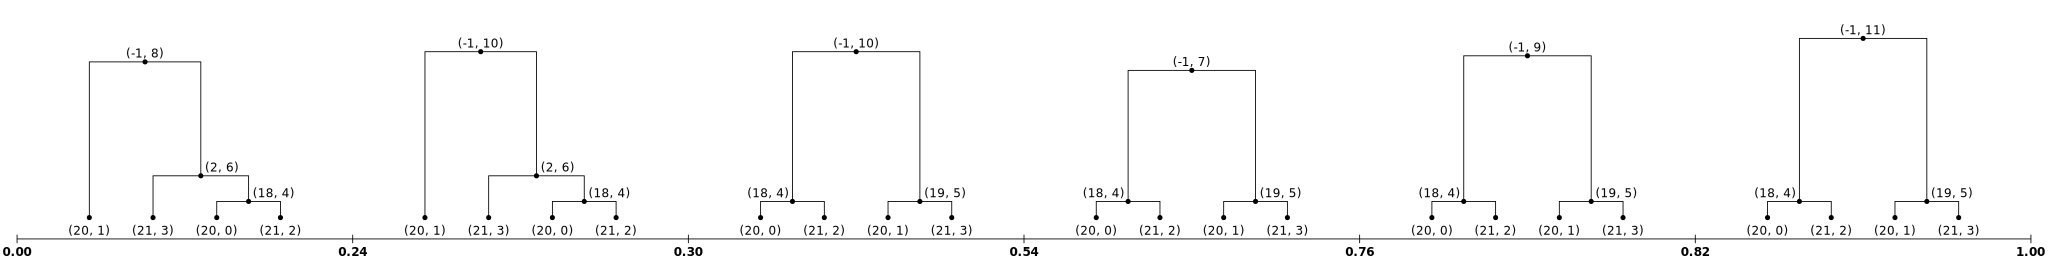

In [10]:
kwargs = dict(tree_height_scale='log_time', node_labels=labels, size=(ts.num_trees*400, 300))
SVG(ts.draw_svg(**kwargs, path='../fig/ts_loop_4_seed_241.svg'))

In [11]:
class Agent:
    def __init__(self, node, ts, ref_count=1):
        self.node = node
        self.ts = ts
        self.ancestors = self.ancestral_graph()
    
    def __repr__(self):
        return f"Agent @{self.node}: {self.ancestors}"

    def ancestral_graph(self):
        """This implementation only keeps nodes with parents in the dictionary
        Alternatively, we can have terminal nodes with empty sets"""
        ag = defaultdict(set)

        for tree in self.ts.trees():
            node = self.node
            parent = tree.parent(node)
            while parent is not tskit.NULL:
                
                ag[node].add(parent)
                node = parent
                parent = tree.parent(node)
        return ag

In [12]:
Agent(0, ts)

Agent @0: defaultdict(<class 'set'>, {0: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}})

In [13]:
Agent(1, ts)

Agent @1: defaultdict(<class 'set'>, {1: {8, 10, 5}, 5: {9, 10, 11, 7}})

In [14]:
agents = [Agent(sample, ts) for sample in ts.samples()]
agents

[Agent @0: defaultdict(<class 'set'>, {0: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}}),
 Agent @1: defaultdict(<class 'set'>, {1: {8, 10, 5}, 5: {9, 10, 11, 7}}),
 Agent @2: defaultdict(<class 'set'>, {2: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}}),
 Agent @3: defaultdict(<class 'set'>, {3: {5, 6}, 6: {8, 10}, 5: {9, 10, 11, 7}})]

In [15]:
individual_matching = {sample: labels[sample][0] for sample in ts.samples()}
individual_matching

{0: 20, 1: 20, 2: 21, 3: 21}

In [16]:
K, idx = D.kinship_lange(progress=False)

In [17]:
climber = Climber(D, source=[39, 40, 41, 42])

for t in range(D.generations):
    scores = []
    for ped_node, ped_parents in climber.step_up(t):
        print(ped_node, ped_parents, t)
        if ped_parents:
            climber.queue(ped_parents[1])
    

40 [37, 38] 0
41 [35, 36] 0
42 [37, 38] 0
39 [35, 36] 0
36 [29, 30] 1
38 [33, 34] 1
34 [23, 24] 2
30 [19, 20] 2
24 [11, 12] 3
20 [7, 8] 3
8 [] 4
12 [3, 4] 4


In [18]:
climber = Climber(D, source=[39, 40, 41, 42])


for ped_node, ped_parents in climber:
    print(ped_node, ped_parents)
    if ped_parents:
        climber.queue(ped_parents[1])

40 [37, 38]
41 [35, 36]
42 [37, 38]
39 [35, 36]
36 [29, 30]
38 [33, 34]
34 [23, 24]
30 [19, 20]
24 [11, 12]
20 [7, 8]
8 []
12 [3, 4]


In [19]:
labels

{0: (20, 0),
 1: (20, 1),
 2: (21, 2),
 3: (21, 3),
 4: (18, 4),
 5: (19, 5),
 6: (2, 6),
 7: (-1, 7),
 8: (-1, 8),
 9: (-1, 9),
 10: (-1, 10),
 11: (-1, 11)}

In [20]:
def preorder_dist(tree):
    stack = [(tree.root, 0)]
    while len(stack) > 0:
        u, distance = stack.pop()
        yield u, distance
        for v in tree.children(u):
            delta = tree.time(u) - tree.time(v)
            stack.append((v, distance + delta))
            
            
def tree_distances(ts):
    n = ts.num_nodes
    L = np.zeros((n, n))

    for tree in tqdm(ts.trees(), total=ts.num_trees):
        l = np.zeros((n, n))
        r = tree.root
        for i, dist in preorder_dist(tree):
            l[i, r] = dist
            l[r, i] = dist

        nodes = list(tree.nodes())
        nodes.remove(r)

        for i in nodes:
            for j in nodes:
                m = tree.mrca(i, j)
                l[i, j] = l[i, r] + l[j, r] - (2 * l[m, r])

        L += l * tree.span
    return L

In [21]:
L = tree_distances(ts)
L[L==0] = np.inf

100%|██████████| 6/6 [00:00<00:00, 3538.00it/s]


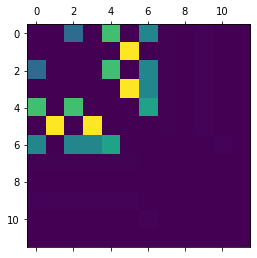

In [22]:
plt.matshow(1/L)

In [24]:
proband_nodes = [39, 40, 41, 42]
climber = Climber(D, source=proband_nodes)

agents = [Agent(sample, ts) for sample in ts.samples()]

prob_idx = [idx[p] for p in proband_nodes]


for t in range(D.generations):
    scores = {}
    for ped_node, ped_parents in climber.step_up(t):
        if not ped_parents:
            continue
        left_stat = K[idx[ped_parents[0]], prob_idx]
        right_stat = K[idx[ped_parents[1]], prob_idx]
        # up_stat = L[gen_parent, proband_nodes].todense()

        if ped_parents:
            climber.queue(ped_parents[1])

In [27]:
ts.samples()

array([0, 1, 2, 3], dtype=int32)

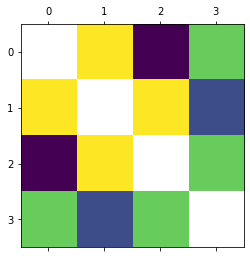

In [32]:
plt.matshow(L[:4, :4])

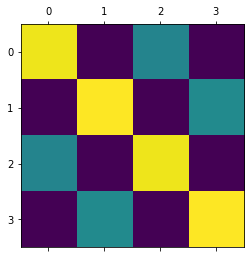

In [38]:
plt.matshow(K[38:42, 38:42])

In [36]:
proband_nodes

[39, 40, 41, 42]

In [37]:
list(39:42)

SyntaxError: invalid syntax (<ipython-input-37-7ead1134e937>, line 1)

In [30]:
agents

[Agent @0: defaultdict(<class 'set'>, {0: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}}),
 Agent @1: defaultdict(<class 'set'>, {1: {8, 10, 5}, 5: {9, 10, 11, 7}}),
 Agent @2: defaultdict(<class 'set'>, {2: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}}),
 Agent @3: defaultdict(<class 'set'>, {3: {5, 6}, 6: {8, 10}, 5: {9, 10, 11, 7}})]

In [32]:
a = Agent(0, ts)
a

Agent @0: defaultdict(<class 'set'>, {0: {4}, 4: {6, 7, 9, 10, 11}, 6: {8, 10}})

In [34]:
a.ancestors.pop(0)

{4}

In [35]:
a.ancestors

defaultdict(set, {4: {6, 7, 9, 10, 11}, 6: {8, 10}})